Origen de datos:https://www.kaggle.com/NUFORC/ufo-sightings#complete.csv

Context
This dataset contains over 80,000 reports of UFO sightings over the last century.

Content
There are two versions of this dataset: scrubbed and complete. The complete data includes entries where the location of the sighting was not found or blank (0.8146%) or have an erroneous or blank time (8.0237%). Since the reports date back to the 20th century, some older data might be obscured. Data contains city, state, time, description, and duration of each sighting.

Inspiration
What areas of the country are most likely to have UFO sightings?
Are there any trends in UFO sightings over time? Do they tend to be clustered or seasonal?
Do clusters of UFO sightings correlate with landmarks, such as airports or government research centers?
What are the most common UFO descriptions?
Acknowledgement
This dataset was scraped, geolocated, and time standardized from NUFORC data by Sigmond Axel here.

In [3]:
import pandas as pd
import time
from datetime import date
from datetime import time
import matplotlib.pyplot as plt
import re

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import stem
from nltk.stem import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
ps = PorterStemmer()

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="ironhack")
from geopy.util import get_version
get_version()

data = pd.read_csv('./UFO.csv')

[nltk_data] Downloading package stopwords to /home/laura/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/laura/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/laura/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
data.shape

(88875, 14)

In [3]:
data.columns

Index(['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)',
       'duration (hours/min)', 'comments', 'date posted', 'latitude',
       'longitude', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13'],
      dtype='object')

In [4]:
data.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.9411111,NaN,NaN,NaN
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082,NaN,NaN,NaN
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667,NaN,NaN,NaN
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.6458333,NaN,NaN,NaN
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.8036111,NaN,NaN,NaN


In [5]:
data.dtypes

datetime                 object
city                     object
state                    object
country                  object
shape                    object
duration (seconds)       object
duration (hours/min)     object
comments                 object
date posted              object
latitude                 object
longitude                object
Unnamed: 11              object
Unnamed: 12             float64
Unnamed: 13             float64
dtype: object

In [6]:
data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce') #datetime to datetime
data['duration (seconds)'] = pd.to_numeric(data['duration (seconds)'], errors='coerce') #duration (seconds) to float
data['latitude'] = pd.to_numeric(data['latitude'], errors='coerce') #latitud to float
data['longitude'] = pd.to_numeric(data['longitude'], errors='coerce') #longitude to float
data.dtypes
data['city'] = data['city'].str.title()
data['state'] = data['state'].str.upper()
data['country'] = data['country'].str.upper()

In [7]:
print(data['duration (seconds)'].max())
print(data['duration (seconds)'].min())

97836000.0
0.0


In [8]:
print(data['datetime'].min())
print(data['datetime'].max())

1906-11-11 00:00:00
2014-05-08 18:45:00


In [9]:
#split in date and time:
data['date'] = [d.date() for d in data['datetime']]
data['year'] = data.datetime.dt.year

data['time'] = data.datetime.dt.time
#data.head()

In [10]:
data.isnull().sum()
#hay que eliminar las columnas: Unnamed: 11 (88197), Unnamed: 12 (88836), Unnamed: 13 (88873)

datetime                 1262
city                      196
state                    7396
country                 12401
shape                    3358
duration (seconds)        403
duration (hours/min)     3090
comments                  154
date posted                 3
latitude                  679
longitude                  39
Unnamed: 11             88197
Unnamed: 12             88836
Unnamed: 13             88873
date                     1262
year                     1262
time                     1262
dtype: int64

In [11]:
# eliminamos las columnas que tienen casi todos los valores, nulos:
data1 = data.drop(['Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13','duration (hours/min)'], axis=1).dropna(subset=['latitude', 'longitude'], inplace=False)
#tambien las filas cuyos valores de 'latitud' o 'longitud' son nulos:
data1 = data1[data1['latitude'] != 0.000000]
#tenemos que quitar las latitudes fuera del rango [-90, 90] y las longitudes que esten en [-180, 180]:
#data1 = data1[data1['latitude'] >= -90 and data1['latitude'] <= 90 ]
data1 = data1[(data1['latitude'].between(-90,90)) & (data1['longitude'].between(-180,180))]
#.dropna(axis=0, how='any', inplace=False)
#tambien las filas cuyos valores de 'latitud' o 'longitud' son nulos:
#data1.dropna(subset=['name', 'born'])

In [12]:
data1.head(143)

,datetime,city,state,country,shape,duration (seconds),comments,date posted,latitude,longitude,date,year,time
0,1949-10-10 20:30:00,San Marcos,TX,US,cylinder,2700.0,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,1949-10-10,1949.0,20:30:00
1,1949-10-10 21:00:00,Lackland Afb,TX,NaN,light,7200.0,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082,1949-10-10,1949.0,21:00:00
2,1955-10-10 17:00:00,Chester (Uk/England),NaN,GB,circle,20.0,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667,1955-10-10,1955.0,17:00:00
3,1956-10-10 21:00:00,Edna,TX,US,circle,20.0,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,1956-10-10,1956.0,21:00:00
4,1960-10-10 20:00:00,Kaneohe,HI,US,light,900.0,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,1960-10-10,1960.0,20:00:00
5,1961-10-10 19:00:00,Bristol,TN,US,sphere,300.0,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.595000,-82.188889,1961-10-10,1961.0,19:00:00
6,1965-10-10 21:00:00,Penarth (Uk/Wales),NaN,GB,circle,180.0,penarth uk circle 3mins stayed 30ft above m...,2/14/2006,51.434722,-3.180000,1965-10-10,1965.0,21:00:00
7,1965-10-10 23:45:00,Norwalk,CT,US,disk,1200.0,A bright orange color changing to reddish colo...,10/2/1999,41.117500,-73.408333,1965-10-10,1965.0,23:45:00
8,1966-10-10 20:00:00,Pell City,AL,US,disk,180.0,Strobe Lighted disk shape object observed clos...,3/19/2009,33.586111,-86.286111,1966-10-10,1966.0,20:00:00
9,1966-10-10 21:00:00,Live Oak,FL,US,disk,120.0,Saucer zaps energy from powerline as my pregna...,5/11/2005,30.294722,-82.984167,1966-10-10,1966.0,21:00:00


In [13]:
data1.country.unique()

array(['US', nan, 'GB', 'CA', 'AU', 'DE'], dtype=object)

In [14]:
#En la columna Country hay muchos valores erroneos: en un primer momento vamos a sustituir algunos valores:
data1['country'] = data1['country'].replace(['WI', 'FL', 'HI', 'IA', 'KS', 'UT', 'MI', 'WV', 'WY','VT', 'ND', 'NJ','NM', 'NV', 'NY', 'OR', 'TX'], 'US')
data1['country'] = data1['country'].replace(['AB', 'BC', 'MB', 'PQ', 'QC', ' ??) (CANADA)'], 'CA')
data1['country'] = data1['country'].replace(['DC'], 'DK')
data1['country'] = data1['country'].replace([' (CATALUNYA) (SPAIN)'], 'SP')
data1['country'] = data1['country'].replace([' (FINLAND)'], 'FI')
data1['country'] = data1['country'].replace(['N (SWEDEN)',  '(SWEDEN)', 'SAND (SWEDEN)',' (SWEDEN)'], 'SE')
data1['country'] = data1['country'].replace(['Y (NORWAY)',  'NDELAG (NORWAY)'], 'NO')
data1['country'] = data1['country'].replace([' POD RALSKEM (CZECH REPUBLIC)'], 'CZ')
data1['country'] = data1['country'].replace(['A (ARGENTINA)'], 'AR')
data1['country'] = data1['country'].replace(['RITO SANTO STATE) (BRAZIL)', ' CERRO PRIETO.&#44 B. C.'], 'BR')

data1.country.fillna('other',inplace=True)

#data1[data.country.isnull()]
data1.country.unique()

array(['US', 'other', 'GB', 'CA', 'AU', 'DE'], dtype=object)

In [15]:
data1.latitude.max(), data1.latitude.min(), data1.longitude.max(), data1.longitude.min()

(72.7, -82.862752, 178.4419, -176.65805559999998)

In [16]:
data1.country.value_counts()

US       70105
other    10554
CA        3243
GB        2038
AU         578
DE         111
Name: country, dtype: int64

In [17]:
# Para los datos en los que 'country' es un valor nulo, lo vamos a sustituir por el valor que nos devuelve geolocator al hacer la consulta con los datos de latitud y longitud:

def adress_state (lat, lon):
    coord = str(lat) + ' , '+ str(lon)
    location = geolocator.reverse(coord)
    res = location.raw['address']['state']
    return res
        
def adress_country(lat, lon, country):
    if country != 'other':
        return country
    else: 
        try: 
            coord = str(lat) + ' , '+ str(lon)
            location = geolocator.reverse(coord)
            res2 = location.raw['address']['country']
            return res2
        except: 
            return 'timeout'

#PARA PROBAR LA FUNCION:
print(adress_country(29.883056, -97.941111, 'other'))
      

#DESBLOQUEAR AL FINAL!!!data1['country'] = data1.apply(lambda x: adress_country(x['latitude'], x['longitude'], x['country']), axis = 1)
   # else:
        #i


#data['country'] = data['country'].fillna(data.apply(lambda x: adress_country(x['latitude'], x['longitude']), axis = 1))

# data1['state'] = data1.apply(lambda x: adress_state(x['latitude'], x['longitude']), axis = 1)
#data['country'] = data.apply(lambda x: adress_country(x['latitude'], x['longitude']), axis = 1)

#data.head()
#data.longitude

USA


In [18]:
#data1.to_csv("UFO_modify1.csv")

In [4]:
data_m = pd.read_csv('./UFO_modify1.csv')
data_m.head()

,Unnamed: 0,datetime,city,state,country,shape,duration (seconds),comments,date posted,latitude,longitude,date,year,time
0,0,1949-10-10 20:30:00,San Marcos,TX,US,cylinder,2700.0,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,1949-10-10,1949.0,20:30:00
1,1,1949-10-10 21:00:00,Lackland Afb,TX,timeout,light,7200.0,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082,1949-10-10,1949.0,21:00:00
2,2,1955-10-10 17:00:00,Chester (Uk/England),NaN,GB,circle,20.0,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667,1955-10-10,1955.0,17:00:00
3,3,1956-10-10 21:00:00,Edna,TX,US,circle,20.0,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,1956-10-10,1956.0,21:00:00
4,4,1960-10-10 20:00:00,Kaneohe,HI,US,light,900.0,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,1960-10-10,1960.0,20:00:00


In [5]:
data_m.country.value_counts()

US             70105
timeout        10526
CA              3243
GB              2038
AU               578
DE               111
USA               14
España             2
UK                 2
Brasil             2
Portugal           1
Sverige            1
Slovenija          1
Philippines        1
India              1
Ghana              1
México             1
Malaysia           1
Name: country, dtype: int64

In [6]:
#vamos a eliminar las filas cuyo pais es 'timeout':
data_m = data_m[data_m['country'] != 'timeout']

#homogeneizamos los valores de la columna 'country':

data_m['country'] = data_m['country'].replace(['USA'], 'US')
data_m['country'] = data_m['country'].replace(['México'], 'MX')

data_m.country.unique()

array(['US', 'GB', 'CA', 'AU', 'Portugal', 'DE', 'Ghana', 'India',
       'España', 'UK', 'Sverige', 'Malaysia', 'Brasil', 'Slovenija', 'MX',
       'Philippines'], dtype=object)

In [7]:
#Antes de hacer el analisis de NLP, debemos eliminar las filas con valores nulos:
data_clean = data_m.dropna(axis=0, how='any', inplace=False)
data_clean['year'] = data_clean['year'].astype(int)
data_clean['duration (seconds)'] = data_clean['duration (seconds)'].astype(int)

data_clean.country.unique()

/home/laura/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/laura/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


array(['US', 'CA', 'AU', 'GB', 'MX'], dtype=object)

In [8]:
#guardamos en .csv el data limpio, listo para los graficos en Tableau:

data_clean.to_csv("UFO_modify2.csv")

In [24]:
#análisis NLP: atencion a cambiar el nombre del Dataset!!!
#tambien faltan por definir las Stop Words

#vocab = list()
#for e in list(rank_blabla.index):
    #autor = raw_df[raw_df["Autor"] == e]
    
#seleccionamos las ultimas 50000 filas:

texto = list(data_clean["comments"])[:-50000]

#limpiamos los carateres especiales y los numeros:

def clean_up(s):
    pattern = '[^a-z]+'
    x = re.sub(pattern, ' ', str(s).lower())
    return x.split('http')[0]

In [25]:
#análisis NLP: atencion a cambiar el nombre del Dataset!!!
#tambien faltan por definir las Stop Words

#vocab = list()
#for e in list(rank_blabla.index):
    #autor = raw_df[raw_df["Autor"] == e]
    
#seleccionamos las ultimas 50000 filas:


def tokenize(s):
    return word_tokenize(s)

texto_s = clean_up(texto)

#print (type(texto_s))
#stemming and lemmatizacion:

def stem_and_lemmatize(l):
    lemmatizer = WordNetLemmatizer()
    stemmer = stem.PorterStemmer()
    stem_phrase = [stemmer.stem(x) for x in l]
    stem_and_lemmatizer_phrase = [lemmatizer.lemmatize(x) for x in stem_phrase]
    return stem_and_lemmatizer_phrase

palabras = tokenize(texto_s)

texto_ssl = stem_and_lemmatize(palabras)
texto_ssl

['thi',
 'event',
 'took',
 'place',
 'in',
 'earli',
 'fall',
 'around',
 'it',
 'occur',
 'after',
 'a',
 'boy',
 'scout',
 'meet',
 'in',
 'the',
 'baptist',
 'church',
 'the',
 'baptist',
 'church',
 'sit',
 'my',
 'older',
 'brother',
 'and',
 'twin',
 'sister',
 'were',
 'leav',
 'the',
 'onli',
 'edna',
 'theater',
 'at',
 'about',
 'pm',
 'we',
 'had',
 'our',
 'bike',
 'and',
 'i',
 'took',
 'a',
 'differ',
 'rout',
 'home',
 'a',
 'a',
 'marin',
 'st',
 'lt',
 'fli',
 'an',
 'fj',
 'b',
 'fighter',
 'attack',
 'aircraft',
 'on',
 'a',
 'solo',
 'night',
 'exercis',
 'i',
 'wa',
 'at',
 'in',
 'a',
 'quot',
 'clean',
 'quot',
 'aircraft',
 'no',
 'ordinan',
 'my',
 'father',
 'is',
 'now',
 'my',
 'brother',
 'the',
 'girl',
 'with',
 'u',
 'now',
 'myself',
 'and',
 'the',
 'other',
 'fellow',
 'which',
 'work',
 'with',
 'my',
 'father',
 'if',
 'he',
 's',
 'still',
 'livi',
 'a',
 'bright',
 'orang',
 'color',
 'chang',
 'to',
 'reddish',
 'color',
 'disk',
 'saucer',
 'wa

In [26]:
#TEnemos que eliminar las palabras que no tienen

In [27]:
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(texto_ssl)

bag_of_words = list(vectorizer.get_feature_names())

freq_matrix = X.toarray()

freq_matrix_sum = list(freq_matrix.sum(axis=0))

zipall = list(zip(bag_of_words, freq_matrix_sum))

sorted_zipall = sorted(zipall, key=lambda x: x[1], reverse=True)

#print(sorted_zipall)


#Se deben limpiar algunas stop-words
clean_vocab = list()

stopW = stopwords.words('english')

clean_vocab.append([tuple for tuple in sorted_zipall if tuple[0] not in stopW])
most_common = clean_vocab[0:100]
most_common

[[('light', 1581),
  ('object', 879),
  ('sky', 736),
  ('wa', 581),
  ('bright', 539),
  ('move', 510),
  ('shape', 500),
  ('white', 389),
  ('red', 334),
  ('orang', 323),
  ('saw', 284),
  ('seen', 268),
  ('craft', 262),
  ('fli', 252),
  ('veri', 252),
  ('ufo', 249),
  ('hover', 245),
  ('like', 230),
  ('star', 224),
  ('larg', 207),
  ('night', 186),
  ('green', 181),
  ('quot', 180),
  ('sight', 174),
  ('flash', 168),
  ('north', 167),
  ('two', 166),
  ('blue', 162),
  ('one', 161),
  ('triangl', 160),
  ('look', 157),
  ('color', 150),
  ('abov', 144),
  ('appear', 142),
  ('fast', 132),
  ('high', 132),
  ('south', 131),
  ('disappear', 129),
  ('low', 128),
  ('speed', 127),
  ('ball', 126),
  ('travel', 126),
  ('format', 125),
  ('sound', 125),
  ('glow', 120),
  ('sphere', 120),
  ('three', 120),
  ('west', 117),
  ('across', 115),
  ('firebal', 115),
  ('pd', 115),
  ('silent', 105),
  ('east', 104),
  ('nuforc', 103),
  ('around', 102),
  ('note', 102),
  ('triangul

In [29]:
# print(pd.DataFrame(list(most_common), columns=['freq', 'word']))  

In [30]:
#df_word.to_csv("Lista_palabras.csv")

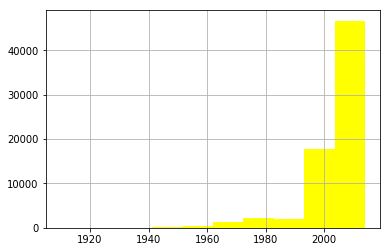

In [31]:
data_clean.year.hist(histtype= 'stepfilled', color = "yellow")

In [32]:
data_year = data1.groupby('year').count()
data_year

,datetime,city,state,country,shape,duration (seconds),comments,date posted,latitude,longitude,date,time
year,,,,,,,,,,,,
1906.0,1,1,0,1,1,1,1,1,1,1,1,1
1910.0,2,2,2,2,2,2,2,2,2,2,2,2
1914.0,1,1,1,1,1,1,1,1,1,1,1,1
1920.0,1,1,1,1,1,1,1,1,1,1,1,1
1925.0,1,1,1,1,1,1,1,1,1,1,1,1
1929.0,1,1,1,1,1,1,1,1,1,1,1,1
1930.0,2,2,2,2,2,2,2,2,2,2,2,2
1931.0,2,2,2,2,2,2,2,2,2,2,2,2
1933.0,1,1,1,1,1,1,1,1,1,1,1,1


In [33]:
data_clean.head()


,Unnamed: 0,datetime,city,state,country,shape,duration (seconds),comments,date posted,latitude,longitude,date,year,time
0,0,1949-10-10 20:30:00,San Marcos,TX,US,cylinder,2700,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,1949-10-10,1949,20:30:00
3,3,1956-10-10 21:00:00,Edna,TX,US,circle,20,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,1956-10-10,1956,21:00:00
4,4,1960-10-10 20:00:00,Kaneohe,HI,US,light,900,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,1960-10-10,1960,20:00:00
5,5,1961-10-10 19:00:00,Bristol,TN,US,sphere,300,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.595000,-82.188889,1961-10-10,1961,19:00:00
7,7,1965-10-10 23:45:00,Norwalk,CT,US,disk,1200,A bright orange color changing to reddish colo...,10/2/1999,41.117500,-73.408333,1965-10-10,1965,23:45:00


In [34]:
df_json = data_clean.to_json()

In [36]:
with open('json_prueba', 'w') as f: 
    f.write(df_json)
